## Classification using PyTorch Neural Networks

### There are many different types of classification: 
1. Binary Classfication
2. Multiclass Classification
3. Multilabel Classification

* Binary Classification is the easiest classification to explain. This is the case that data point represents something we are looking for or it doesnt. For example, a cat and dog classifier where we are checking if the image is a dog will only produce an output by stating whether the image is a dog or it isn't. Binary Classification can use loss functions like Binary Cross Entropy Loss to find and minimize the losses. Also, in cases like Binary Classification we can use functions like the Sigmoid Function or the Step Function or the Hyperbolic Tan Function.

* A Multiclass Classification problem uses the softmax function the convert the output values into probabilities that lie in between 0 and 1 and sum up to 1. From this, we choose the output which the class which the model predicts the highest probability of being by using the argmax
Here, we can also use Cross Entropy Loss but not BCELoss because this problem is not a binary problem.

* A Multilabel Classification problem is much like the first case where we have models checking for each of the labels. If the model predicts a high enough probability that the class belongs to that category then it is a yes otherwise it is a no. We can use the sigmoid activation function here as well to classify the outputs and the loss function used here can be BCELoss in case we are using different models to check for whether the given input belongs to each of the different categories.

Let's get started with a Classification Neural Network in Pytorch using the Circles Dataset from the ScikitLearn Library

### Step 1: Loading, Coverting and Splitting the Data into Train and Test sets

In [30]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

In [11]:
# Let us define the number of samples we want 
no_of_samples = 1000

# Let us create the data 
X, y = make_circles(n_samples=no_of_samples,noise=0.03)

X[:5],y[:5]

(array([[-0.82575898, -0.46796293],
        [ 0.66380981,  0.77517554],
        [ 0.59557462, -0.76029344],
        [-0.18201778,  0.99553435],
        [ 0.70160603,  0.32341624]]),
 array([0, 0, 0, 0, 1], dtype=int64))

In [12]:
# Let us convert the data into a pandas dataframe
df = pd.DataFrame(data={'X1' : X[:,0], 'X2' : X[:,1], 'Label' : y })

df.head()

,X1,X2,Label
0,-0.825759,-0.467963,0
1,0.663810,0.775176,0
2,0.595575,-0.760293,0
3,-0.182018,0.995534,0
4,0.701606,0.323416,1


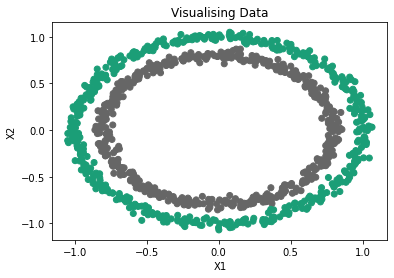

In [18]:
# Now that we have a dataframe we can see that 2 of the X parameters are determining the Label y

#Let us plot a graph of the data and see what it looks like it

plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap='Dark2')
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Visualising Data')

plt.show()

Now that we have gotten the data and visualised it let us split it into Train and Test data and convert the Data into Tensors


In [286]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2, random_state=42)

len(X_train),len(X_test),len(y_train),len(y_test)

(800, 200, 800, 200)

In [287]:
# We now have the arrays in a numpy ndarray format with the training data and the test data. Let us now convert them into PyTorch tensors so they can be used to train and test our model.

X_train = torch.from_numpy(X_train).to(torch.float)
X_test = torch.from_numpy(X_test).to(torch.float)
y_train = torch.from_numpy(y_train).to(torch.float)
y_test = torch.from_numpy(y_test).to(torch.float)


In [288]:

X_train.shape,X_test.shape,y_train.shape

(torch.Size([800, 2]), torch.Size([200, 2]), torch.Size([800]))

Let us setup the device agnostic code and send the arrays to the GPU


In [289]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

In [290]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [291]:
X_train.device

device(type='cuda', index=0)

### Step 2: Create the Model Class 

Initially, we will use 2 Linear layers with weight matrices of shape 2,5 and 5,1 and check how the model performs. Later we will modify the model in order for it to better suit our use case. 

In [241]:
# Now that we have sent all our data to the GPU, Let us start declaring the ANN Class

class ClassificationModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2,5)
        self.output = nn.Linear(5,1)
    
    def forward(self, x) -> torch.Tensor:
         x = self.input(x)
         x = self.output(x)

         return x


model_0 = ClassificationModelV0().to(device)

model_0

ClassificationModelV0(
  (input): Linear(in_features=2, out_features=5, bias=True)
  (output): Linear(in_features=5, out_features=1, bias=True)
)

In [292]:
def computeAccuracy(y_pred,y_target):
    y_pred_rounded = torch.round(torch.sigmoid(y_pred))
    return 100* ((y_pred_rounded == y_target).to(torch.float).sum())/len(y_target)

Here we are defining the function to train the model after choosing the loss function and the number of epochs along with the optimizer which in this case is still stochastic gradient descent.

* We are using the loss function `nn.BCEWithLogitsLoss()`. This function takes in logits as an input which means the numbers can be the raw output value and then converts them through a sigmoid function into probabilities and computes the loss of the each epoch of training and testing.

* There is also the loss function `nn.BCELoss()` where we can use our own sigmoid function or use `torch.sigmoid()` on the output layer and return that but the above function is more optimized for speed. In the case that we do use this function we must ensure that we are providing the probability values are input so it can compute the entropy loss and not the raw values.

In [254]:
def trainModel(): 
    # Let us define the Loss Function and the optimizer functions
    loss_fn = nn.BCEWithLogitsLoss()

    # Now let us choose the optimizer function which will be the SGD function again
    optimizer = torch.optim.SGD(model_0.parameters(),lr=0.05)

    #Let us define the number of epochs that the model will be train for
    epochs = 10000
    for epoch in range(epochs):

        # 1. Forward Propagation
        y_pred = model_0(X_train).squeeze()

        # 2. Calculate loss
        loss = loss_fn(y_pred,y_train)

        # 3. Backprop steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model_0.eval()
        #Testing part
        with torch.inference_mode():
            y_test_pred = model_0(X_test).squeeze()
            accuracy = computeAccuracy(y_pred,y_train)
            test_accuracy = computeAccuracy(y_test_pred,y_test)
            if epoch%1000 ==0:
                print(f'Epoch: {epoch} | Accuracy: {accuracy} | Test Accuracy: {test_accuracy}')


### Step 3: Training the Model

This is the step where we train our model and to keep track of the training progress we will keep printing the losses and accuracies for both the training set and the test set along with the epoch number so we can see how the model is doing.

In [255]:
trainModel()

Epoch: 0 | Accuracy: 50.5 | Test Accuracy: 48.5
Epoch: 1000 | Accuracy: 59.75 | Test Accuracy: 52.5
Epoch: 2000 | Accuracy: 59.875 | Test Accuracy: 52.5
Epoch: 3000 | Accuracy: 59.875 | Test Accuracy: 52.5
Epoch: 4000 | Accuracy: 59.875 | Test Accuracy: 52.5
Epoch: 5000 | Accuracy: 59.875 | Test Accuracy: 52.5
Epoch: 6000 | Accuracy: 59.875 | Test Accuracy: 52.5
Epoch: 7000 | Accuracy: 59.875 | Test Accuracy: 52.5
Epoch: 8000 | Accuracy: 59.875 | Test Accuracy: 52.5
Epoch: 9000 | Accuracy: 59.875 | Test Accuracy: 52.5


### Step 4: Measure model performance

Now that our model has been trained over several thousand epochs we can check our model performance by using the compute accuracy function once again on our final model.

**Oops!** Surprisingly, we note that despite training the model for so long the model has not made much of a progress prediciting with an accuracy close to basic probability laws!

The way we go about fixing this is involved in step 5 where we look at the current results and improvise the model to better suit our data and give better outputs\

* Here we also have the code to download the `helper_functions.py` file from github which contains some useful functions to visualise our data and the decision boundary of data especially in case of non-linear problems like in this case.

In [127]:
# import requests
# from pathlib import Path

# # Downloader helper functions from Learn PyTorch repo (if it's not already downloaded)
# if Path("helper_function.py").is_file():
#     print('helper_functions.py already exists, skipping download')
# else:
#     print('Downloading helper_functions.py')
#     request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
#     with open('helper_functions.py', 'wb') as f:
#         f.write(request.content) 

from helper_functions import plot_predictions, plot_decision_boundary

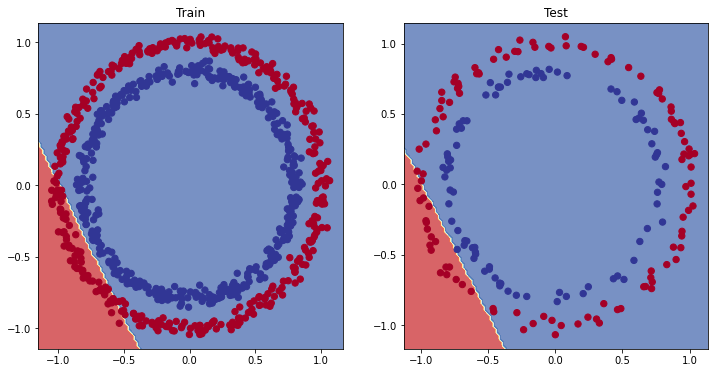

In [256]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_0.cpu(),X_train.cpu(),y_train.cpu())
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_0.cpu(),X_test.cpu(),y_test.cpu())

### Step 5: Improve through Experimentation

#### Now that we have seen that the model is performing poorly for our data which is sorted of expected since we are using linear layers to solve a non-linear problem, we can fix that. However, in general if the model does not perform as you expect then:

#### 1. Reduce the scale of the problem take a smaller dataset and see if the model is learning and performing as you expect. If the model is performing well then you have simply chosen the wrong layers for your current data.

#### 2. There are many ways to change the model to better fit your data
 * Modify the Learning Rate and test it
 * Increase the number of epochs 
 * Change the optimizer algorithm 
 * Change the loss function to a more appropriate one
 * Introduce more depth into the neural network
 * Make the neural network broader
 * Add/Remove non-linearities to/from the network (A non-linear solution for a linear problem or a linear solution for a non-linear problem will always lead to poor results) 


In [298]:
class ClassificationModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.input = nn.Linear(2,10)
        self.relu = nn.ReLU()
        self.hidden = nn.Linear(10,10)
        self.output = nn.Linear(10,1)

    def forward(self,x):
        return self.output(self.relu(self.hidden(self.relu(self.input(x)))))

In [299]:
model_1 = ClassificationModelV1().to(device)
model_1

ClassificationModelV1(
  (input): Linear(in_features=2, out_features=10, bias=True)
  (relu): ReLU()
  (hidden): Linear(in_features=10, out_features=10, bias=True)
  (output): Linear(in_features=10, out_features=1, bias=True)
)

In [300]:
def trainModel1(): 
    # Let us define the Loss Function and the optimizer functions
    loss_fn = nn.BCEWithLogitsLoss()

    # Now let us choose the optimizer function which will be the SGD function again
    optimizer = torch.optim.SGD(model_1.parameters(),lr=0.05)

    #Let us define the number of epochs that the model will be train for
    epochs = 10000
    for epoch in range(epochs):

        # 1. Forward Propagation
        y_pred = model_1(X_train).squeeze()

        # 2. Calculate loss
        loss = loss_fn(y_pred,y_train)

        # 3. Backprop steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model_1.eval()
        #Testing part
        with torch.inference_mode():
            y_test_pred = model_1(X_test).squeeze()
            accuracy = computeAccuracy(y_pred,y_train)
            test_accuracy = computeAccuracy(y_test_pred,y_test)
            if epoch%1000 == 0:
                print(f'Epoch: {epoch} | Accuracy: {accuracy} | Test Accuracy: {test_accuracy}')

In [301]:
trainModel1()

Epoch: 0 | Accuracy: 48.375 | Test Accuracy: 56.5
Epoch: 1000 | Accuracy: 56.625 | Test Accuracy: 49.5
Epoch: 2000 | Accuracy: 96.25 | Test Accuracy: 98.0
Epoch: 3000 | Accuracy: 99.875 | Test Accuracy: 99.5
Epoch: 4000 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 5000 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 6000 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 7000 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 8000 | Accuracy: 100.0 | Test Accuracy: 100.0
Epoch: 9000 | Accuracy: 100.0 | Test Accuracy: 100.0


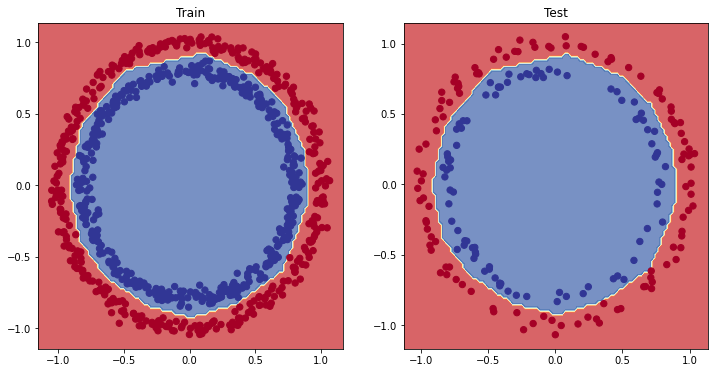

In [303]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title('Train')
plot_decision_boundary(model_1.cpu(),X_train.cpu(),y_train.cpu())
plt.subplot(1,2,2)
plt.title('Test')
plot_decision_boundary(model_1.cpu(),X_test.cpu(),y_test.cpu())

In [308]:
y_pred = model_1(X_test.cpu()).cpu()

# Here we can see that when we are using this as a model to predict the class 
# we must convert put through the sigmoid function and round it down 
# Then, we can get the required class prediction from the model.

y_pred  #torch.round(torch.sigmoid(y_pred))

tensor([[ -5.2089],
        [  8.7439],
        [  7.1727],
        [  6.6844],
        [-12.2040],
        [ -9.2286],
        [  3.7763],
        [  5.8939],
        [ -9.3058],
        [ -8.7647],
        [ -4.1249],
        [  8.1500],
        [  7.3487],
        [ -6.1023],
        [ -4.6843],
        [-12.3886],
        [ -7.5104],
        [ -8.6911],
        [ -9.2503],
        [ -5.3790],
        [ -6.8730],
        [  4.6199],
        [ -7.2976],
        [ -6.2745],
        [  7.9322],
        [ -4.5928],
        [-10.2639],
        [ -9.0869],
        [  5.9627],
        [-13.6290],
        [-10.2423],
        [-11.2070],
        [  3.1449],
        [  7.7293],
        [ -9.8080],
        [ -9.3459],
        [ -5.9123],
        [ -7.1358],
        [  6.6580],
        [  5.9239],
        [ -3.5403],
        [ -4.1725],
        [  7.6626],
        [  7.6783],
        [ -5.0625],
        [  5.6662],
        [  3.9692],
        [  7.9238],
        [ -7.6698],
        [ -5.5762],


### Putting it all together

In this notebook we imported a famous classification data set which cannot be classified by linear means and we saw the accuracy reach a plateau even though we trained it for longer and tried modifying certain parameters. This often means that we are looking at a linear solution for a non-linear problem or vice-versa atleast in case of simple models like this one.

This particular problem was a binary classification problem but now let us look a multiclass classfication problem in a different notebook where we will need to use the softmax function and the CrossEntropyLoss Loss function to train our model and compute the accuracy

As we can see the models accuracy skyrockets to a perfect prediction level after introducing some non-linearity into the model. This is how we improve the model through experimentation. It would be easier if everything was converted to functions to we could call the functions to reset the data as we please. Also, unless necessary do not reassign the data to a different datatype this can cause some issues. 

* **Additional Note:** Through performing this experiment on the local gpu it has been observed that the computation times are much slower than they are on the cpu so for now computing on the cpu when running on the local jupyter enviroment is a better option rather than using the GPU